# Imports

In [1]:
import pandas as pd
from os import getenv
from sqlalchemy import create_engine
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
import contextlib
import numpy as np

# Constants

In [2]:
def check_given_var(env_var_str: str) -> str:
    """
    Check if the given environment variable is set and return its value.

    Args:
        env_var_str (str): The name of the environment variable to check.

    Returns:
        str: The value of the environment variable.

    Raises:
        AssertionError: If the environment variable is not found.
    """

    env_var = getenv(env_var_str)
    assert (
        env_var is not None
    ), f"{env_var_str} is required but not found in environment variables"
    return env_var


def check_env_vars() -> (str, str, str, str):  # type: ignore
    user = check_given_var("DBL_USER")
    database = check_given_var("DBL_DATABASE")
    password = check_given_var("DBL_PASSWORD")
    host = check_given_var("DBL_HOST")
    return user, database, password, host


USER, DATABASE, PASSWORD, HOST = check_env_vars()
# Test database runs waaaaaaaaaaaaaaaaaay faster, yet slow
# USER, DATABASE = "nezox2um_test", "nezox2um_test"
QUERY_ALL = """
SELECT 
    Users.user_id AS user_id, 
    Users.creation_time AS user_creation_time, 
    Users.verified,
    Users.followers_count,
    Users.friends_count,
    Users.statuses_count,
    Users.default_profile,
    Users.default_profile_image,
    Tweets.creation_time AS tweet_creation_time,
    Tweets.tweet_id,
    Tweets.full_text,
    Tweets.lang,
    Tweets.country_code,
    Tweets.favorite_count,
    Tweets.retweet_count,
    Tweets.possibly_sensitive,
    Tweets.replied_tweet_id,
    Tweets.reply_count,
    Tweets.quoted_status_id,
    Tweets.quote_count
FROM Users
INNER JOIN Tweets ON Users.user_id = Tweets.user_id
ORDER BY tweet_creation_time
LIMIT 1000000;
"""
DTYPES = {
"user_id": "object",
"user_creation_time": "datetime64[ns]",
"verified": "bool",
"followers_count": "int32",
"friends_count": "int32",
"statuses_count": "int32",
"default_profile": "bool",
"default_profile_image": "bool",
"tweet_creation_time": "datetime64[ns]",
"tweet_id": "object",
"full_text": "object",
"lang": "category",
"country_code": "category",
"favorite_count": "int32",
"retweet_count": "int32",
"possibly_sensitive": "bool",
"replied_tweet_id": "object",
"reply_count": "int32",
"quoted_status_id": "object",
"quote_count": "int32",
}

COMPANY_NAME_TO_ID = {
    "Klm": "56377143",
    "Air France": "106062176",
    "British Airways": "18332190",
    "American Air": "22536055",
    "Lufthansa": "124476322",
    "Air Berlin": "26223583",
    "Air Berlin assist": "2182373406",
    "easyJet": "38676903",
    "Ryanair": "1542862735",
    "Singapore Airlines": "253340062",
    "Qantas": "218730857",
    "Etihad Airways": "45621423",
    "Virgin Atlantic": "20626359",
}

COMPANY_ID_TO_NAME = {v: k for k, v in COMPANY_NAME_TO_ID.items()}

# Helper functions

In [3]:
def fetch_data(query):
    engine = create_engine(f"mysql://{USER}:{PASSWORD}@{HOST}:3306/{DATABASE}")
    return pd.read_sql_query(query, engine, dtype=DTYPES, index_col='tweet_id')


def get_size_of(size_bytes: float | int) -> str:
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    # Using numpy to calculate the logarithm base 1024
    i = int(np.floor(np.log(size_bytes) / np.log(1024)))
    # Using numpy to calculate power of 1024
    p = np.power(1024, i)
    # Computing the size division
    s = round(size_bytes / p, 2)
    return f"{s} {size_name[i]}"


def identify_dtype(column):
    """
    Identifies the most suitable data type for a pandas Series without loss of information.

    Args:
    column (pd.Series): The pandas Series for which the data type needs to be identified.

    Returns:
    str: Suggested data type as a string.
    """
    # Check if the column can be converted to numeric types (int or float)
    if pd.api.types.is_numeric_dtype(column):
        if not pd.to_numeric(column.dropna(), errors='coerce').notna().all():
            return 'object'  # Fallback if numeric conversion fails

        if not (column.dropna() % 1 == 0).all():
            return 'float'
        # Check range to decide between int types
        min_val, max_val = column.min(), column.max()
        if np.iinfo(np.int8).min <= min_val <= np.iinfo(np.int8).max and max_val <= np.iinfo(np.int8).max:
            return 'int8'
        elif np.iinfo(np.int16).min <= min_val <= np.iinfo(np.int16).max and max_val <= np.iinfo(np.int16).max:
            return 'int16'
        elif np.iinfo(np.int32).min <= min_val <= np.iinfo(np.int32).max and max_val <= np.iinfo(np.int32).max:
            return 'int32'
        else:
            return 'int64'
    # Check if the column can be converted to datetime
    with contextlib.suppress(ValueError, TypeError):
        pd.to_datetime(column)
        return 'datetime'
    # Check if the column should be categorical
    if pd.api.types.is_object_dtype(column):
        num_unique_values = len(column.unique())
        num_total_values = len(column)
        if num_unique_values / num_total_values < 0.5:
            return 'category'

    # Default to object type if none of the above conditions are met
    return 'object'


def get_full_language_name(language_code):
    """
    Convert a two-letter language code (ISO 639-1) to its full language name.
    
    Parameters:
    language_code (str): The two-letter ISO 639-1 language code.
    
    Returns:
    str: The full name of the language or a message indicating the code was not found.
    """
    try:
        # Lookup the language by the ISO 639-1 code
        language = pycountry.languages.get(alpha_2=language_code)
        return language.name
    except AttributeError:
        # Return a default message if the language code is not found
        return "Unknown Language"


def get_country_name(country_code):
    """
    Convert a two-letter country code (ISO 3166-1 alpha-2|) to its full country name.
    
    Parameters:
    country_code (str): The two-letter ISO 3166-1 alpha-2 country code.
    
    Returns:
    str: The full name of the country or a message indicating the code was not found.
    """
    try:
        # Lookup the country by the ISO 3166-1 alpha-2 code
        country = pycountry.countries.get(alpha_2=country_code)
        return country.name
    except AttributeError:
        # Return a default message if the country code is not found
        return "Unknown Country"
    


# Loading

In [4]:
test_data = fetch_data(QUERY_ALL)

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 773176127 to 1147984862516846592
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   user_id                1000000 non-null  object        
 1   user_creation_time     1000000 non-null  datetime64[ns]
 2   verified               1000000 non-null  bool          
 3   followers_count        1000000 non-null  int32         
 4   friends_count          1000000 non-null  int32         
 5   statuses_count         1000000 non-null  int32         
 6   default_profile        1000000 non-null  bool          
 7   default_profile_image  1000000 non-null  bool          
 8   tweet_creation_time    1000000 non-null  datetime64[ns]
 9   full_text              1000000 non-null  object        
 10  lang                   1000000 non-null  category      
 11  country_code           1000000 non-null  category      
 12  favorite_coun

In [6]:
get_size_of(test_data.memory_usage(index=False, deep=True).sum())

'449.48 MB'

In [7]:
test_data.describe()

,user_creation_time,followers_count,friends_count,statuses_count,tweet_creation_time,favorite_count,retweet_count,reply_count,quote_count
count,1000000,1.000000e+06,1.000000e+06,1.000000e+06,1000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000
mean,2013-05-08 08:15:47.048507136,9.452793e+04,5.914586e+03,1.166007e+05,2019-06-11 21:30:29.364389376,1.972671e+01,6.790620,1.329928,1.766951
min,2006-05-24 15:51:44,0.000000e+00,0.000000e+00,0.000000e+00,2008-03-18 04:43:39,0.000000e+00,0.000000,0.000000,0.000000
25%,2010-05-23 19:25:54.500000,9.600000e+01,1.670000e+02,1.662000e+03,2019-06-06 21:56:32.500000,0.000000e+00,0.000000,0.000000,0.000000
50%,2012-09-28 18:54:36,3.860000e+02,4.210000e+02,9.389000e+03,2019-06-14 20:30:17.500000,0.000000e+00,0.000000,0.000000,0.000000
75%,2016-04-13 17:18:36.500000,1.689000e+03,1.190000e+03,4.311400e+04,2019-06-25 14:27:51,0.000000e+00,0.000000,0.000000,0.000000
max,2019-07-07 21:09:21,1.057294e+08,4.541583e+06,6.944156e+06,2019-07-07 21:44:54,1.538783e+06,508393.000000,169843.000000,125661.000000
std,NaN,5.491528e+05,2.347991e+04,3.610804e+05,NaN,2.482405e+03,847.179815,214.979672,221.618398


# Visualisations

# Database size

In [8]:
# I'm too lazy

## Language related

In [9]:
# Change later to "un" instead fo "und"
lang_popularity_df = test_data.reset_index().groupby('lang', observed=True)\
    .count()[['tweet_id']]\
    .sort_values('tweet_id', ascending=False)
all_tweets = lang_popularity_df["tweet_id"].sum()
lang_popularity_df["fraction"] = lang_popularity_df["tweet_id"] * 100 / all_tweets
top_5_popularity_lang = lang_popularity_df.head()
top_5_popularity_lang

,tweet_id,fraction
lang,,
en,761580,76.1580
es,46602,4.6602
fr,34843,3.4843
un,30469,3.0469
nl,22753,2.2753


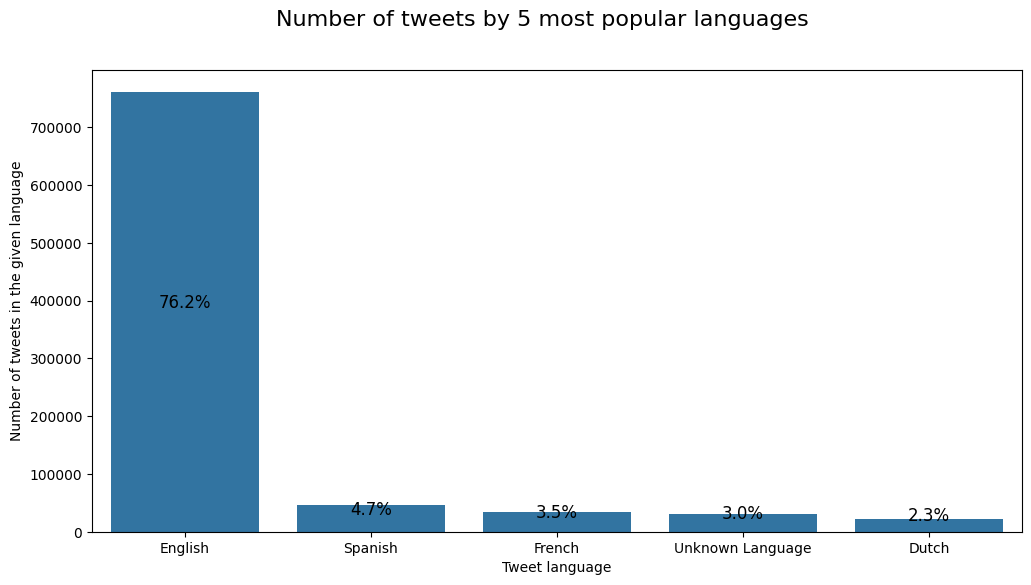

In [10]:
# Your existing code for plotting
top_5_popularity_lang_full = top_5_popularity_lang.reset_index().copy()
top_5_popularity_lang_full["lang"] = top_5_popularity_lang_full["lang"].apply(get_full_language_name)
top_5_popularity_lang_full["fraction"] = np.round(top_5_popularity_lang_full["fraction"], 1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.barplot(data=top_5_popularity_lang_full, x='lang', y='tweet_id', ax=ax)

# Annotating each bar with the fraction value
for p, frac in zip(ax.patches, top_5_popularity_lang_full['fraction']):
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() /2, f'{frac}%', 
            fontsize=12, ha='center', va='bottom')

# Setting labels and title
ax.set_ylabel('Number of tweets in the given language')
ax.set_xlabel('Tweet language')
fig.suptitle('Number of tweets by 5 most popular languages', size=16);

## Country of origin

In [11]:
# Change later to "un" instead fo "und"
country_df = test_data.reset_index().groupby('country_code', observed=True).count()[['tweet_id']].sort_values('tweet_id', ascending=False)
all_tweets = country_df["tweet_id"].sum()
country_df["fraction"] = np.round(country_df["tweet_id"] * 100 / all_tweets, 1)
# country_df = country_df.head(10)
country_df

,tweet_id,fraction
country_code,,
un,967102,96.7
US,12146,1.2
GB,7402,0.7
AU,1462,0.1
DE,1305,0.1
...,...,...
AQ,1,0.0
AM,1,0.0
SL,1,0.0


In [12]:
country_df_plot = country_df.reset_index().copy()
country_df_plot["country_code"] = country_df_plot["country_code"].apply(get_country_name)
country_df_plot

,country_code,tweet_id,fraction
0,Unknown Country,967102,96.7
1,United States,12146,1.2
2,United Kingdom,7402,0.7
3,Australia,1462,0.1
4,Germany,1305,0.1
...,...,...,...
164,Antarctica,1,0.0
165,Armenia,1,0.0
166,Sierra Leone,1,0.0
167,Senegal,1,0.0


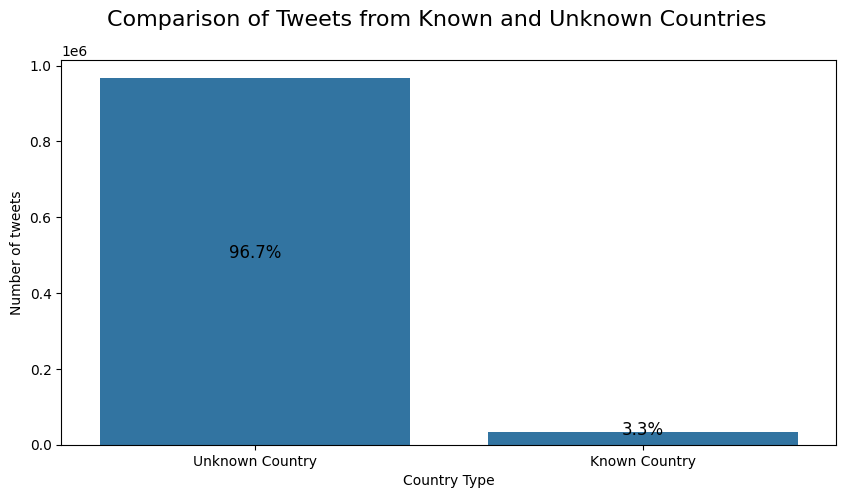

In [13]:

# Aggregate the data by the new column to sum tweet_id
summary = country_df_plot.copy()
summary['Country Type'] = summary['country_code'].apply(lambda x: 'Unknown Country' if x == 'Unknown Country' else 'Known Country')
summary = summary.groupby('Country Type')[['tweet_id']].sum().reset_index().sort_values('tweet_id', ascending=False)
summary["fraction"] = np.round(summary["tweet_id"] / summary["tweet_id"].sum() * 100, 1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.barplot(data=summary, x='Country Type', y='tweet_id', ax=ax)

# Annotating each bar with the fraction value
for p, frac in zip(ax.patches, summary['fraction']):
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() /2, f'{frac}%', 
            fontsize=12, ha='center', va='bottom')

# Setting labels and title
ax.set_ylabel('Number of tweets')
fig.suptitle('Comparison of Tweets from Known and Unknown Countries', size=16);

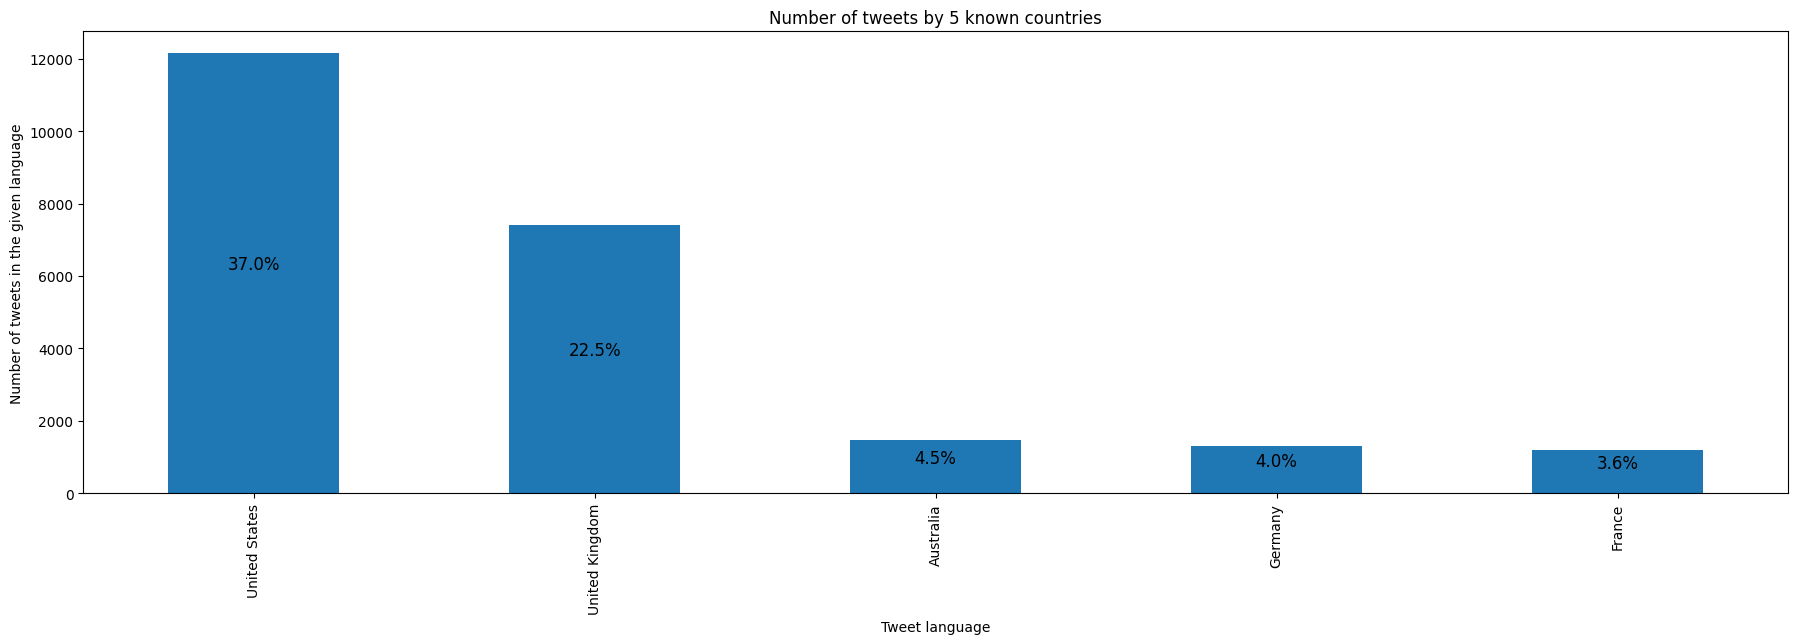

In [14]:
# Your existing code for plotting
df_plot_by_country = country_df_plot[country_df_plot["country_code"] != "Unknown Country"].copy()
df_plot_by_country["fraction"] = np.round(df_plot_by_country["tweet_id"] / df_plot_by_country["tweet_id"].sum() * 100, 1)
df_plot_by_country = df_plot_by_country.head()
ax = df_plot_by_country[["country_code", "tweet_id"]].plot(kind="bar", x="country_code",
    y="tweet_id", figsize=(22, 6), title='Number of tweets by 5 known countries',
    ylabel='Number of tweets in the given language', xlabel='Tweet language', legend=False)

# Annotating each bar with the fraction value
for p, frac in zip(ax.patches, df_plot_by_country['fraction']):
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() /2, f'{frac}%', 
            fontsize=12, ha='center', va='bottom')

## Tweets from main accounts of the airlines

In [15]:
avia_names = set(COMPANY_NAME_TO_ID.values())

replies_to_avia_companies_df = test_data.loc[test_data['user_id'].apply(lambda x: any(x == avia_name for avia_name in avia_names))]
replies_to_avia_companies_df = replies_to_avia_companies_df.reset_index().groupby("user_id").count()[['tweet_id']].sort_values('tweet_id', ascending=False).reset_index()

replies_to_avia_companies_df["user_id"] = replies_to_avia_companies_df["user_id"].apply(lambda user_id: COMPANY_ID_TO_NAME.get(user_id, user_id))
replies_to_avia_companies_df = replies_to_avia_companies_df.set_index("user_id")
replies_to_avia_companies_df

,tweet_id
user_id,
American Air,22648
British Airways,17268
easyJet,9114
Klm,5774
Ryanair,4179
Virgin Atlantic,3086
Lufthansa,2379
Qantas,2057
Air France,1589


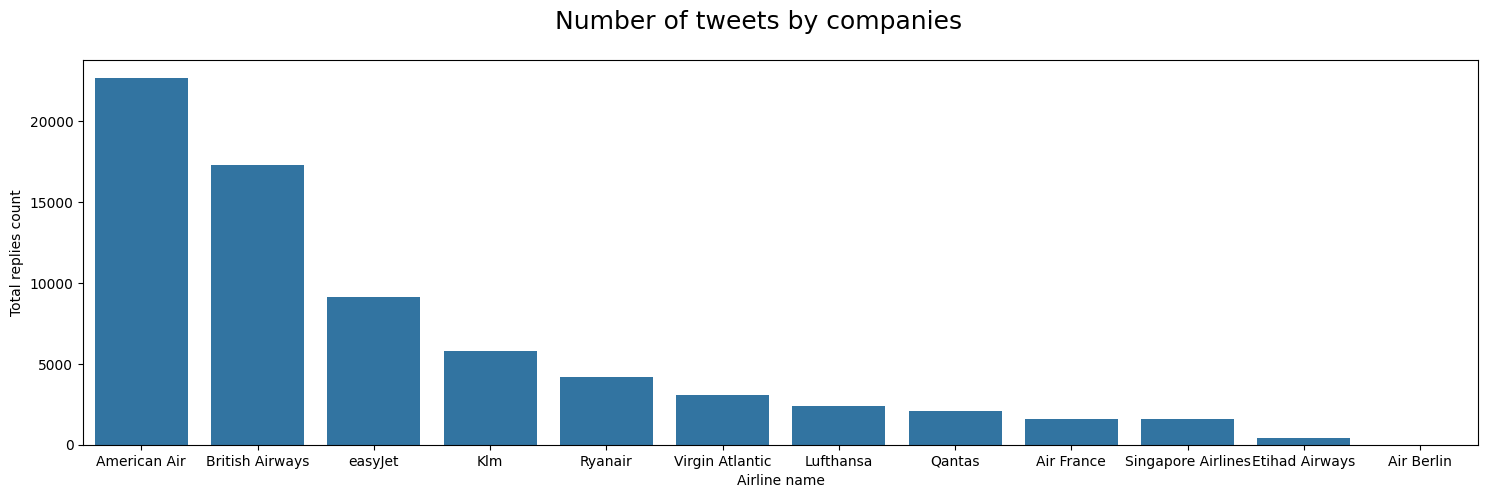

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,5))
sns.barplot(data=replies_to_avia_companies_df, ax=ax, x='user_id', y='tweet_id')
ax.set_ylabel('Total replies count')
ax.set_xlabel('Airline name')
fig.suptitle('Number of tweets by companies', size=18);

## Replies to company posts

In [17]:
# I'm too lazy
all_replies = test_data[test_data["replied_tweet_id"].notna()][["tweet_creation_time", "replied_tweet_id",]]
all_replies = all_replies.reset_index().rename(columns={'tweet_creation_time': 'reply_creation_time',
                            "tweet_id": "reply_id",
                            "replied_tweet_id": "original_tweet_id"})
gay = test_data["tweet_creation_time"].to_dict()
all_replies['original_tweet_creation_time'] = all_replies['original_tweet_id'].map(gay)
all_replies = all_replies[all_replies["original_tweet_creation_time"].notna()]
all_replies["airline_name"] = all_replies["reply_id"].map(COMPANY_ID_TO_NAME)
all_replies[all_replies["airline_name"].notna()]
# why 0?????????

,reply_id,reply_creation_time,original_tweet_id,original_tweet_creation_time,airline_name


## Companies' activity and popularity in social media

In [18]:
test_data_no_index = test_data.reset_index().copy()
popularity_by_airlines = test_data_no_index.reset_index().loc[test_data_no_index['user_id']\
    .apply(lambda x: any(x == avia_name for avia_name in avia_names))]\
    .groupby("user_id")\
    .agg(
          tweet_number=("tweet_id", "count"),
          retweet_count=("retweet_count", "sum"),
          favorite_count=("favorite_count", "sum"),
          reply_count=("reply_count", "sum"),
          quote_count=("quote_count", "sum"),
          ).reset_index()
popularity_by_airlines["user_id"] = popularity_by_airlines["user_id"].apply(lambda user_id: COMPANY_ID_TO_NAME.get(user_id, user_id))
popularity_by_airlines = popularity_by_airlines.set_index("user_id").sort_values("retweet_count", ascending=False)
popularity_by_airlines

,tweet_number,retweet_count,favorite_count,reply_count,quote_count
user_id,,,,,
British Airways,17268,35611,127366,13049,6609
Etihad Airways,397,34580,36267,1856,816
Qantas,2057,33499,94063,2774,8039
Ryanair,4179,32215,48174,11601,5889
Klm,5774,17352,56949,3404,1458
American Air,22648,9241,24659,2039,827
Singapore Airlines,1577,4289,13286,837,683
Lufthansa,2379,2372,15032,566,166
Air Berlin,5,1308,3334,212,170


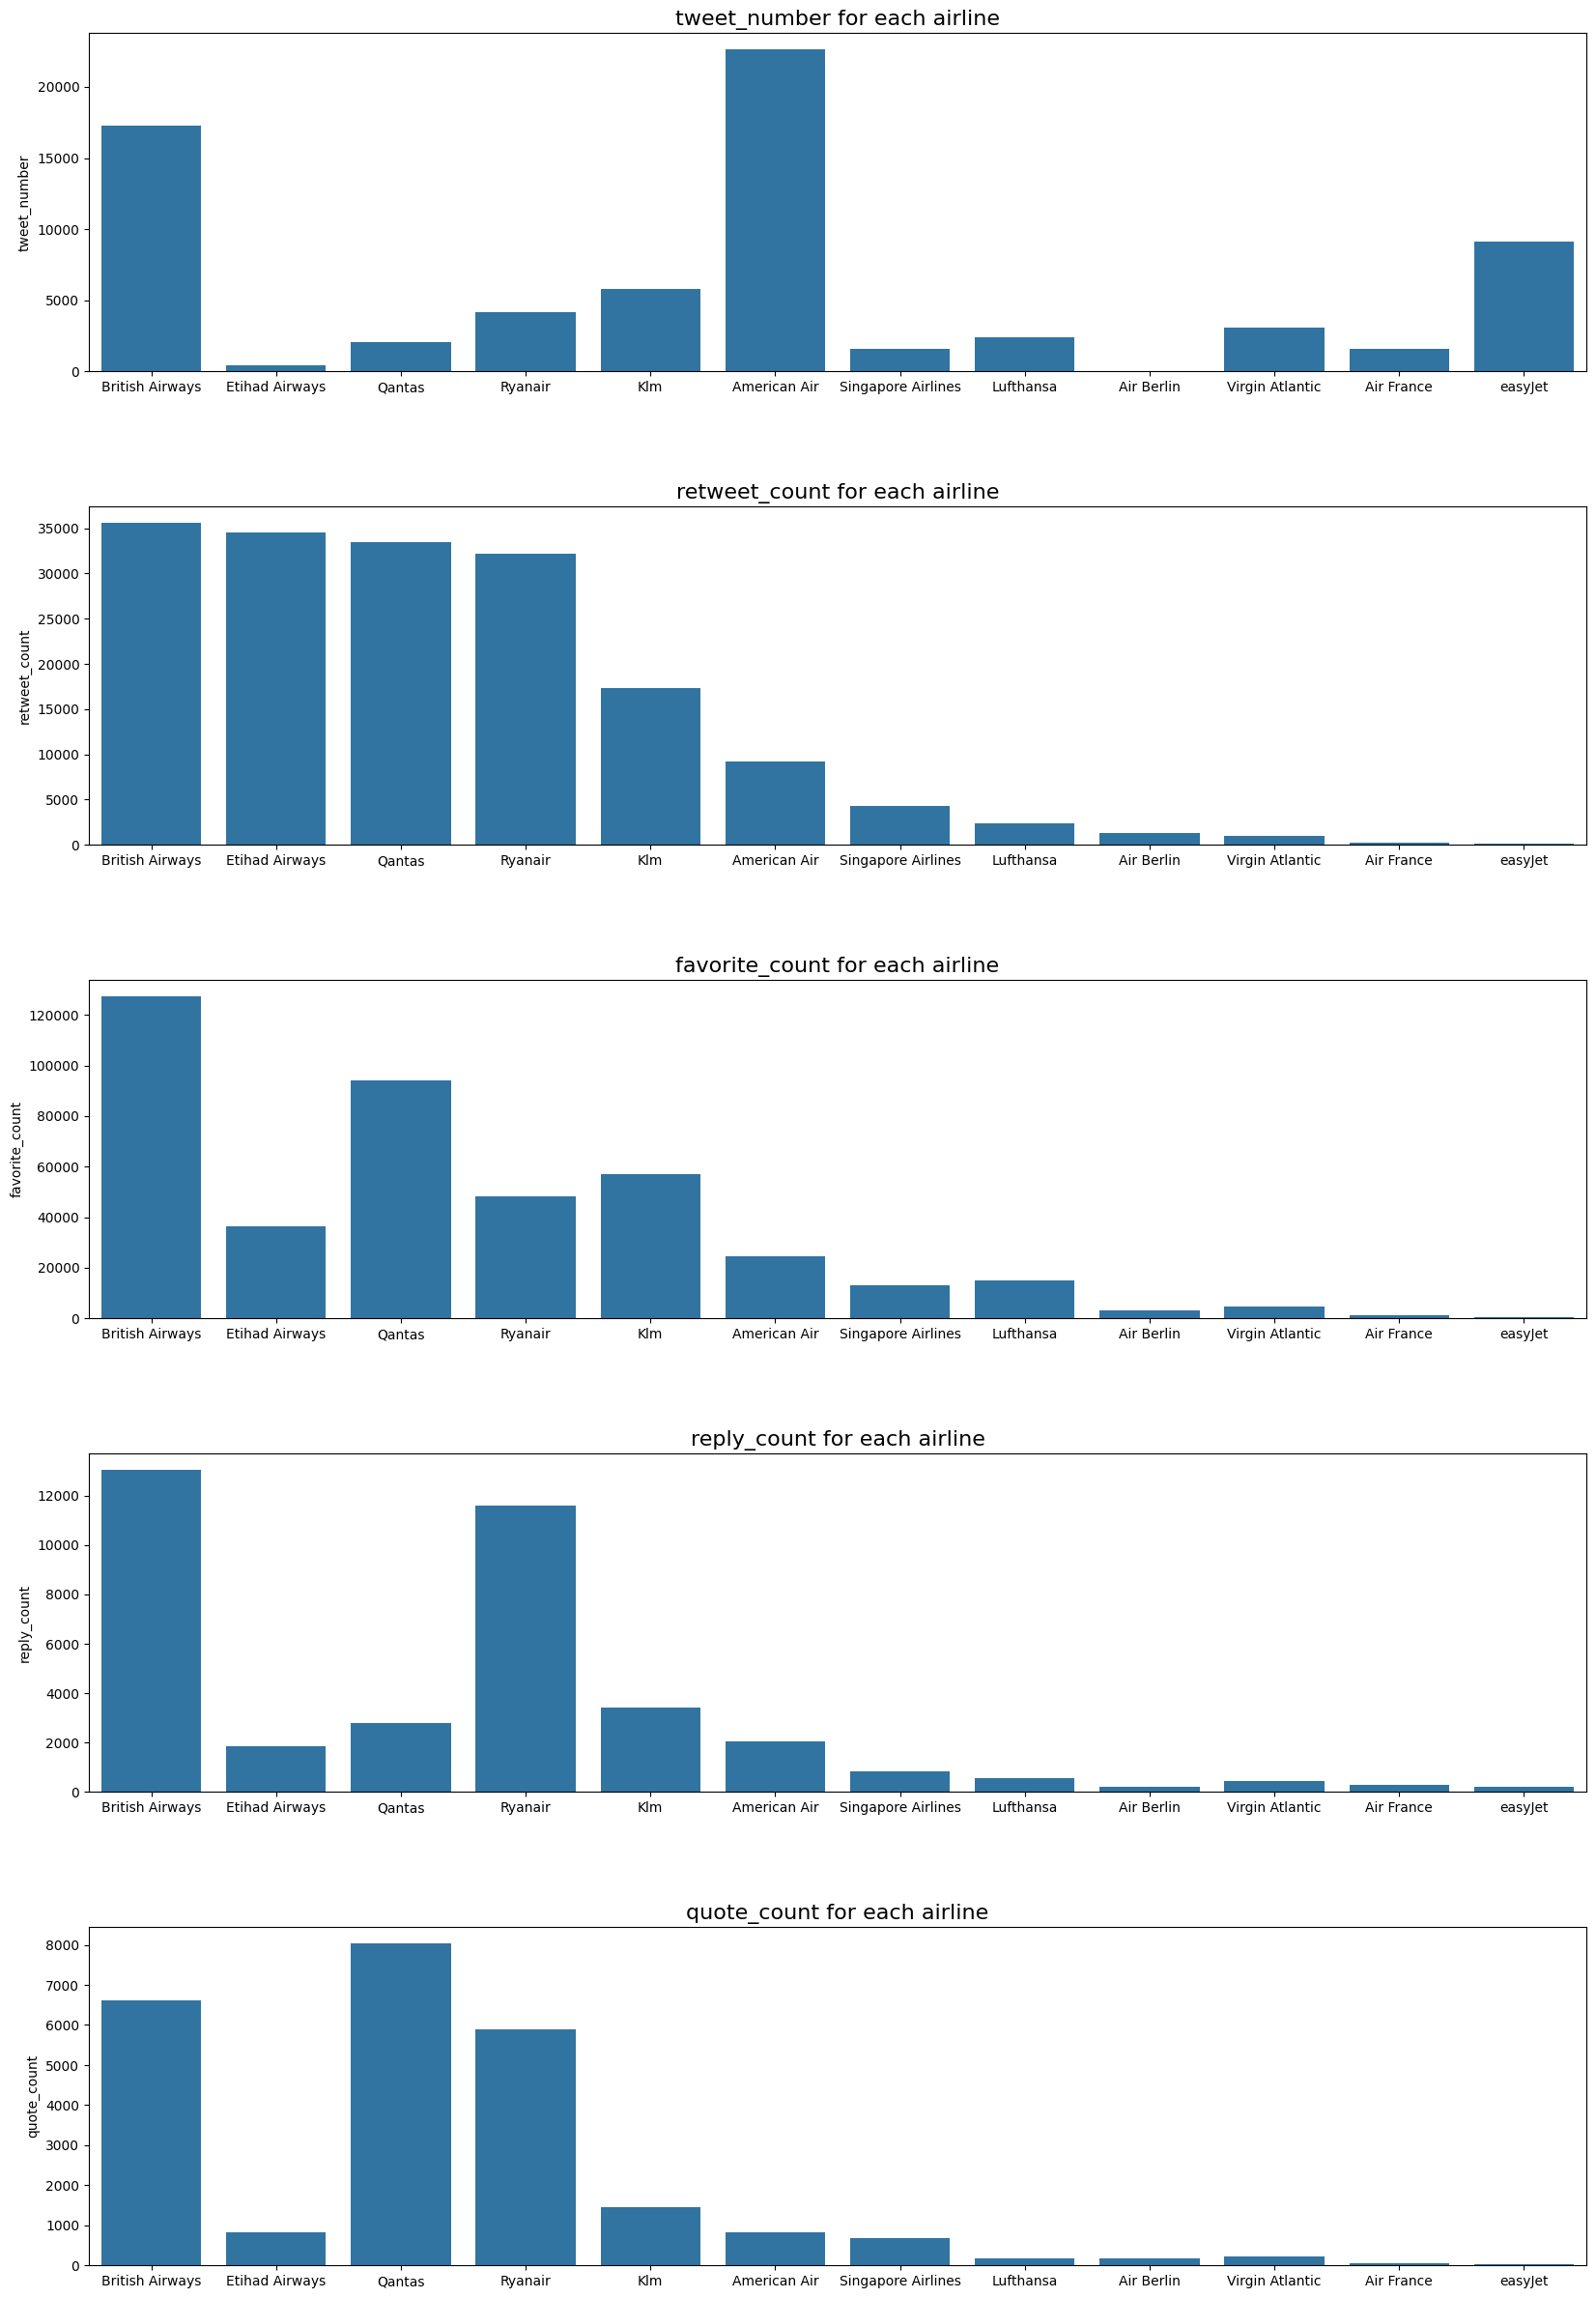

In [19]:
fig, ax = plt.subplots(nrows=len(popularity_by_airlines.columns),
                       figsize=(20, 6 * len(popularity_by_airlines.columns)))

for index, column in enumerate(popularity_by_airlines.columns):
    df_column = popularity_by_airlines
    sns.barplot(data=df_column, x='user_id', y=column, ax=ax[index])
    ax[index].set_title(f"{column} for each airline", size=16)
    ax[index].set_xlabel("")
fig.subplots_adjust(hspace=0.4)

## Information regarding users

In [20]:
df_users = test_data_no_index.copy().groupby("user_id")
df_users = df_users.agg(
    user_creation_time=("user_creation_time", "min"),
    verified=("verified", "min"),
    followers_count=("followers_count", "min"),
    friends_count=("friends_count", "min"),
    statuses_count=("statuses_count", "min"),
    default_profile=("default_profile", "min"),
    default_profile_image=("default_profile_image", "max"),
    tweet_number=("tweet_id", "count"),
    first_tweet=("tweet_creation_time", "min"),
    last_tweet=("tweet_creation_time", "max"),
    possibly_sensitive=("possibly_sensitive", "sum"),
    favorite_count=("favorite_count", "sum"),
    retweet_count=("retweet_count", "sum"),
    reply_count=("reply_count", "sum"),
    quote_count=("quote_count", "sum"),
    lang=("lang", "first")
)
df_users.head()

,user_creation_time,verified,followers_count,friends_count,statuses_count,default_profile,default_profile_image,tweet_number,first_tweet,last_tweet,possibly_sensitive,favorite_count,retweet_count,reply_count,quote_count,lang
user_id,,,,,,,,,,,,,,,,
1000002812087099394,2018-05-25 13:17:04,False,111,77,9938,True,False,1,2019-06-07 14:31:48,2019-06-07 14:31:48,0,0,0,0,0,en
1000003777070444544,2018-05-25 13:20:54,False,52,49,303,True,False,1,2019-05-24 13:57:03,2019-05-24 13:57:03,0,0,0,0,0,ja
1000004316550320128,2018-05-25 13:23:03,False,2644,1967,4846,True,False,1,2019-05-24 17:26:15,2019-05-24 17:26:15,0,0,0,0,0,en
1000004765336600582,2018-05-25 13:24:50,False,520,703,880,True,False,1,2019-06-07 19:08:24,2019-06-07 19:08:24,0,0,0,0,0,en
1000005433426407426,2018-05-25 13:27:29,False,344,435,39978,True,False,1,2019-06-08 13:03:15,2019-06-08 13:03:15,0,0,0,0,0,pt


In [21]:
df_users.describe()

,user_creation_time,followers_count,friends_count,statuses_count,tweet_number,first_tweet,last_tweet,possibly_sensitive,favorite_count,retweet_count,reply_count,quote_count
count,533807,5.338070e+05,5.338070e+05,5.338070e+05,533807.000000,533807,533807,533807.000000,5.338070e+05,533807.000000,533807.000000,533807.000000
mean,2013-10-01 04:46:47.705695488,7.497051e+03,9.890937e+02,2.576134e+04,1.873336,2019-06-09 11:01:42.353896192,2019-06-12 15:06:27.259036416,0.011875,3.695476e+01,12.721115,2.491402,3.310093
min,2006-05-24 15:51:44,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,2008-03-18 04:43:39,2008-03-18 05:03:55,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,2011-01-24 08:42:19.500000,7.600000e+01,1.600000e+02,1.286000e+03,1.000000,2019-06-07 07:06:15.500000,2019-06-07 17:03:47,0.000000,0.000000e+00,0.000000,0.000000,0.000000
50%,2013-04-26 15:49:11,2.680000e+02,3.740000e+02,6.580000e+03,1.000000,2019-06-11 20:37:36,2019-06-16 05:13:30,0.000000,0.000000e+00,0.000000,0.000000,0.000000
75%,2016-08-08 21:06:23,8.210000e+02,8.580000e+02,2.446800e+04,1.000000,2019-06-24 03:20:05,2019-06-26 04:26:05,0.000000,0.000000e+00,0.000000,0.000000,0.000000
max,2019-07-07 21:09:21,1.057294e+08,4.541583e+06,6.944156e+06,22648.000000,2019-07-07 21:44:54,2019-07-07 21:44:54,121.000000,1.921671e+06,715486.000000,322423.000000,125661.000000
std,NaN,3.389324e+05,8.707462e+03,6.330365e+04,46.621715,NaN,NaN,0.270704,3.972001e+03,1387.413651,497.697077,329.773154


### Custom user "trustworthiness" classification

,verified
verified,
False,525137
True,8670


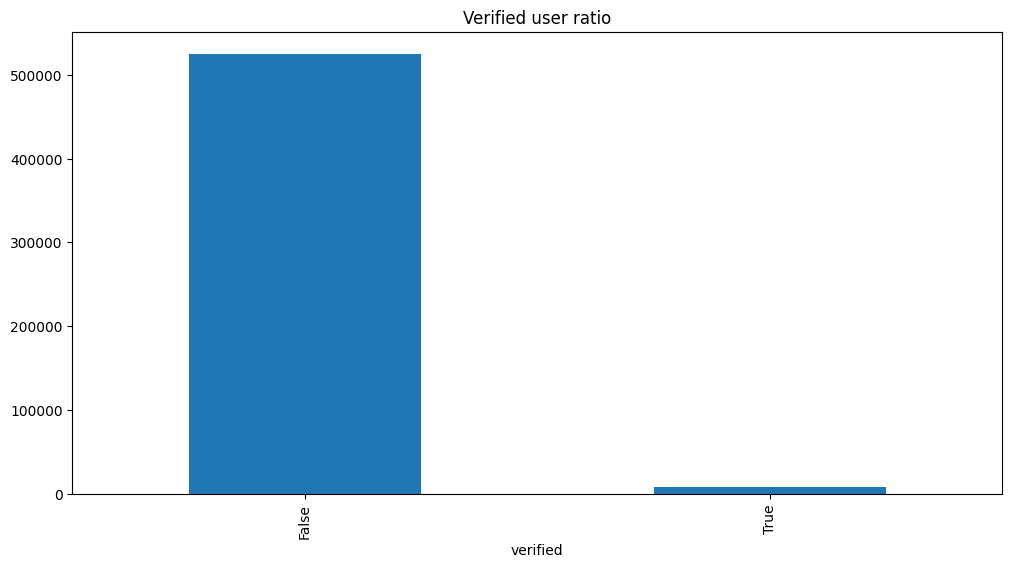

In [22]:
df_verified = df_users.groupby("verified").agg(verified=("user_creation_time", "count"))
df_verified.plot(kind="bar", title="Verified user ratio", legend=False, figsize=(12, 6))
df_verified

,default_profile
default_profile,
False,257626
True,276181


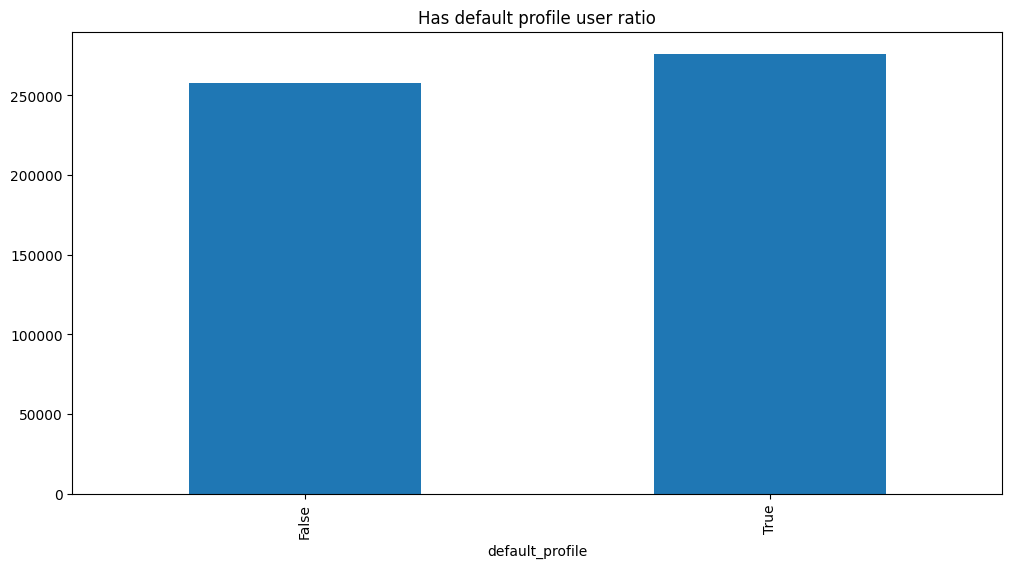

In [23]:
default_profile = df_users.groupby("default_profile").agg(default_profile=("user_creation_time", "count"))
default_profile.plot(kind="bar", title="Has default profile user ratio", legend=False, figsize=(12, 6))
default_profile

,default_profile_image
default_profile_image,
False,533807


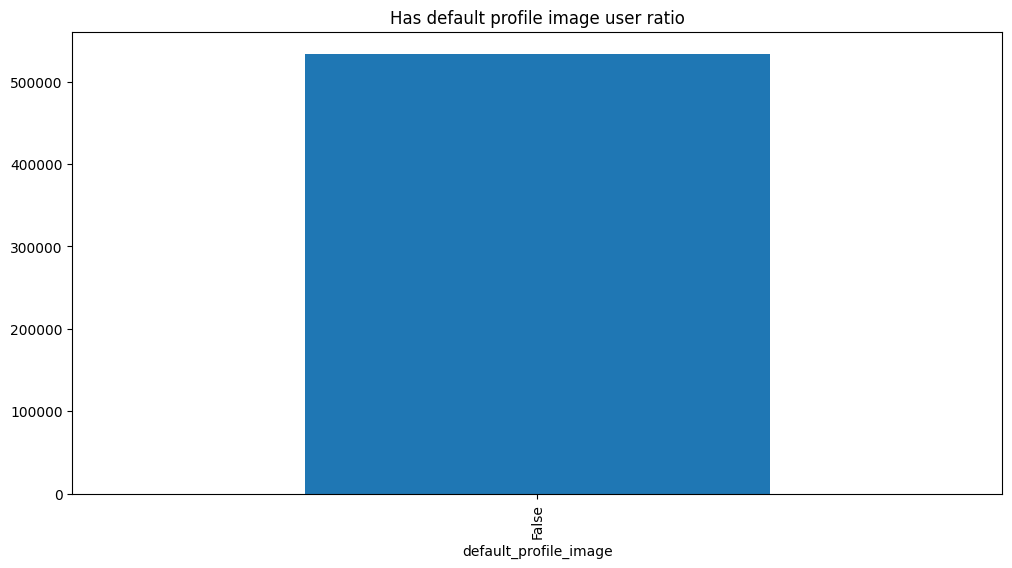

In [24]:
default_profile_image = df_users.groupby("default_profile_image").agg(default_profile_image=("user_creation_time", "count"))
default_profile_image.plot(kind="bar", title="Has default profile image user ratio", legend=False, figsize=(12, 6))
default_profile_image

In [25]:
df_users["time_to_tweet"] = df_users["first_tweet"] - df_users["user_creation_time"]
df_users["time_to_tweet"].describe()

count                          533807
mean     2077 days 06:14:54.648200608
std      1189 days 07:03:04.632417280
min                   0 days 00:00:26
25%                1033 days 20:06:48
50%                2232 days 19:12:48
75%         3059 days 01:19:37.500000
max                4746 days 22:45:14
Name: time_to_tweet, dtype: object

## Tweets information

In [26]:
df_sensitive = test_data.groupby("possibly_sensitive").count()[["user_id"]]
df_sensitive

,user_id
possibly_sensitive,
False,993661
True,6339


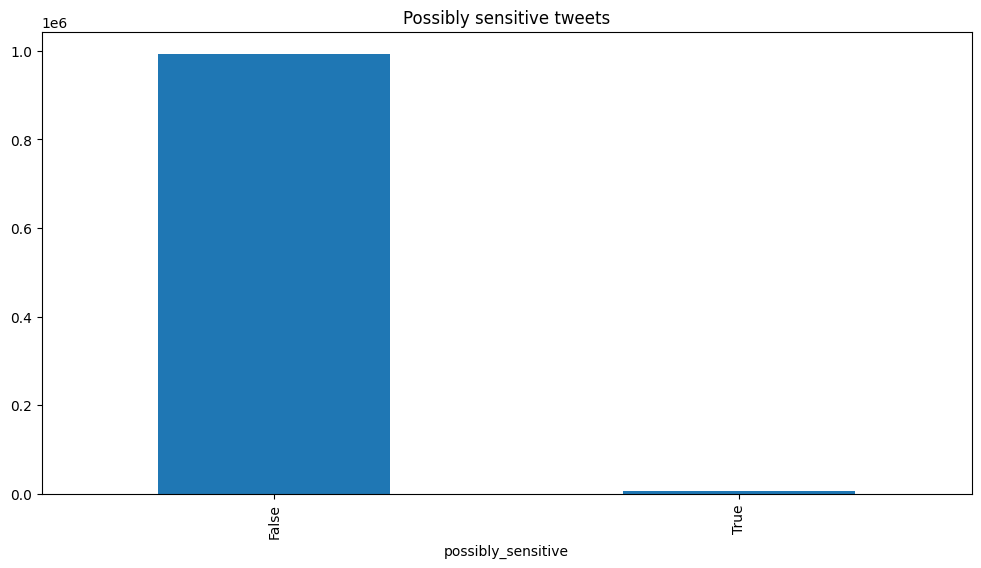

In [27]:
df_sensitive.plot(kind="bar", title="Possibly sensitive tweets", legend=False, figsize=(12, 6));